# Preprocessing, EDA, feature engineering

data source: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/data

### About the data

- data gathered at two solar power plants in India over period of 34 days
- two pairs of files: each pair with power generation data and sensor reading dataset
- power generation data gathered at the inverter level at 15 min. intervals - each inverter has multiple lines of solar panels attached to it
- sensor data is gathered at plant level - single array of sensors optimally placed at plant

Plant 1: Gandikotta, Andhra </br>
Plant 2: Nasik, Maharashtra

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import sagemaker
import boto3
from dotenv import load_dotenv
import os
from faker import Faker

In [47]:
load_dotenv() # .env wit AWS configure and bucket name

boto_session = boto3.Session(
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    aws_session_token=os.getenv("AWS_SESSION_TOKEN"),
    region_name=os.getenv("AWS_DEFAULT_REGION"),
)

s3 = boto_session.client("s3")
bucket = os.getenv("S3_BUCKET")

p1gen_file_path = "data/Plant_1_Generation_Data.csv"
p2gen_file_path = "data/Plant_2_Generation_Data.csv"
p1weather_file_path = "data/Plant_1_Weather_Sensor_Data.csv"
p2weather_file_path = "data/Plant_2_Weather_Sensor_Data.csv"

s3.download_file(bucket, p1gen_file_path, p1gen_file_path)
s3.download_file(bucket, p2gen_file_path, p2gen_file_path)
s3.download_file(bucket, p1weather_file_path, p1weather_file_path)
s3.download_file(bucket, p2weather_file_path, p2weather_file_path)

p1gen = pd.read_csv(p1gen_file_path)
p2gen = pd.read_csv(p2gen_file_path)
p1weather = pd.read_csv(p1weather_file_path)
p2weather = pd.read_csv(p2weather_file_path)

[01/24/25 15:25:05] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=974531;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=174666;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 15:25:06] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=710642;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=758011;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 15:25:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=269779;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=775459;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=761296;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=322195;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

In [48]:
# format datetime
p1gen["DATE_TIME"] = pd.to_datetime(p1gen["DATE_TIME"], format="%d-%m-%Y %H:%M")
p2gen["DATE_TIME"] = pd.to_datetime(p2gen["DATE_TIME"], format="%Y-%m-%d %H:%M:%S")
p1weather['DATE_TIME']= pd.to_datetime(p1weather['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
p2weather['DATE_TIME']= pd.to_datetime(p2weather['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

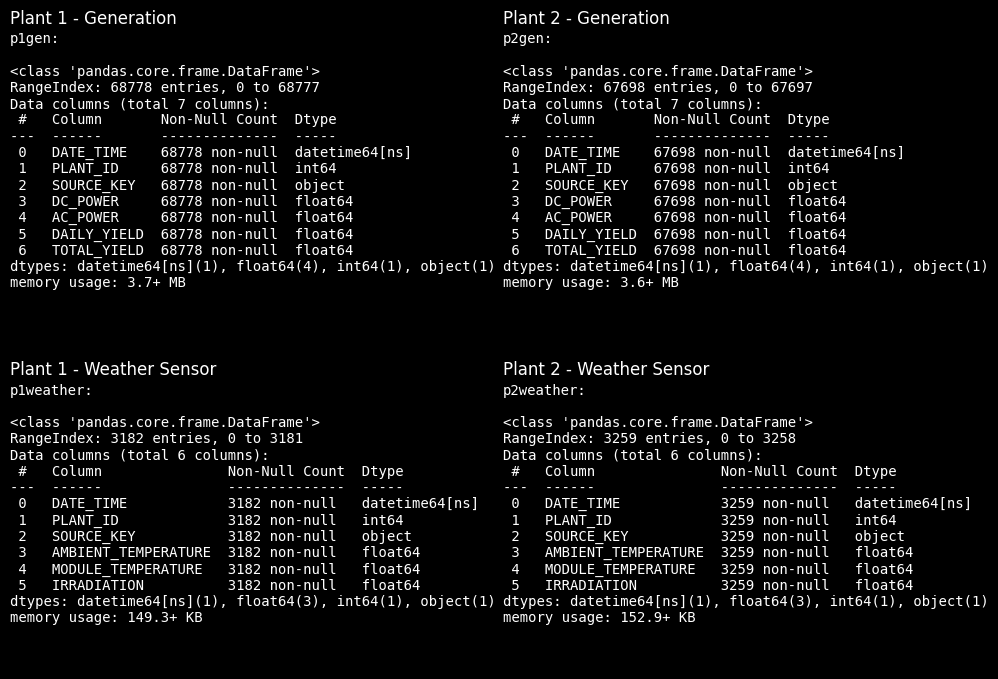

In [49]:
def get_info_text(df):
    buffer = StringIO()
    df.info(buf=buffer)
    return buffer.getvalue()

dfs = [("p1gen", p1gen), ("p2gen", p2gen), ("p1weather", p1weather), ("p2weather", p2weather)]

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.patch.set_facecolor("black")
axes = axes.flatten()
columns = ["Plant 1", "Plant 2"]
rows = ["Generation", "Weather Sensor"]

for i, (name, df) in enumerate(dfs):
    ax = axes[i]
    ax.set_facecolor("black") 
    ax.axis("off")  
    info_text = get_info_text(df) 
    ax.text(
        0, 1, f"{name}:\n\n{info_text}",
        fontsize=10,
        va="top",
        ha="left",
        family="monospace",
        color="white" 
    )
    row, col = divmod(i, 2)
    ax.set_title(f"{columns[col]} - {rows[row]}", fontsize=12, color="white", loc="left")
fig.tight_layout(pad=1.0)
plt.show()

keine "Null"-Werte, aber 0-Werte

In [50]:
# p1gen DC Power is wrong by factor 10
p1gen['DC_POWER'] = p1gen['DC_POWER'] / 10

In [51]:
p1gen.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,2020-06-01 08:02:49.458256896,4135001.0,314.742621,307.802752,3295.968737,6.978712e+06
min,2020-05-15 00:00:00,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,2020-05-24 00:45:00,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,2020-06-01 14:30:00,4135001.0,42.900000,41.493750,2658.714286,7.146685e+06
75%,2020-06-09 20:00:00,4135001.0,636.696429,623.618750,6274.000000,7.268706e+06
max,2020-06-17 23:45:00,4135001.0,1447.112500,1410.950000,9163.000000,7.846821e+06
std,NaN,0.0,403.645717,394.396439,3145.178309,4.162720e+05


In [52]:
p2gen.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,67698,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04
mean,2020-06-01 10:44:33.650625024,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08
min,2020-05-15 00:00:00,4136001.0,0.000000,0.000000,0.000000,0.000000e+00
25%,2020-05-23 21:00:00,4136001.0,0.000000,0.000000,272.750000,1.996494e+07
50%,2020-06-01 23:00:00,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08
75%,2020-06-09 23:30:00,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09
max,2020-06-17 23:45:00,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09
std,NaN,0.0,370.569597,362.112118,2919.448386,7.296678e+08


In [53]:
print(f"p1gen # Quellen: {p1gen['SOURCE_KEY'].nunique()}")
print(f"p2gen # Quellen: {p2gen['SOURCE_KEY'].nunique()}")

p1gen # Quellen: 22
p2gen # Quellen: 22


In [54]:
sources = pd.concat([p1gen["SOURCE_KEY"], p2gen["SOURCE_KEY"]]).unique()
source_ids = range(1, len(sources) + 1)
fake = Faker()
generated_names = [fake.first_name() for _ in range(44)]
key_to_id_mapping = dict(zip(sources, source_ids))
key_to_name_mapping = dict(zip(sources, generated_names))
p1gen["NAME"] = p1gen["SOURCE_KEY"].map(key_to_name_mapping)
p2gen["NAME"] = p2gen["SOURCE_KEY"].map(key_to_name_mapping)
p1gen["SOURCE_ID"] = p1gen["SOURCE_KEY"].map(key_to_id_mapping)
p2gen["SOURCE_ID"] = p2gen["SOURCE_KEY"].map(key_to_id_mapping)
key_to_name_mapping

{'1BY6WEcLGh8j5v7': 'John',
 '1IF53ai7Xc0U56Y': 'Hector',
 '3PZuoBAID5Wc2HD': 'Jason',
 '7JYdWkrLSPkdwr4': 'Alexis',
 'McdE0feGgRqW7Ca': 'Sarah',
 'VHMLBKoKgIrUVDU': 'Mary',
 'WRmjgnKYAwPKWDb': 'Diana',
 'ZnxXDlPa8U1GXgE': 'Larry',
 'ZoEaEvLYb1n2sOq': 'Robert',
 'adLQvlD726eNBSB': 'Barry',
 'bvBOhCH3iADSZry': 'William',
 'iCRJl6heRkivqQ3': 'Cassandra',
 'ih0vzX44oOqAx2f': 'Kevin',
 'pkci93gMrogZuBj': 'Emily',
 'rGa61gmuvPhdLxV': 'Emily',
 'sjndEbLyjtCKgGv': 'Ashley',
 'uHbuxQJl8lW7ozc': 'Heather',
 'wCURE6d3bPkepu2': 'Kathleen',
 'z9Y9gH1T5YWrNuG': 'Dalton',
 'zBIq5rxdHJRwDNY': 'Robert',
 'zVJPv84UY57bAof': 'Julie',
 'YxYtjZvoooNbGkE': 'Linda',
 '4UPUqMRk7TRMgml': 'Jeremy',
 '81aHJ1q11NBPMrL': 'Edward',
 '9kRcWv60rDACzjR': 'Nicole',
 'Et9kgGMDl729KT4': 'Travis',
 'IQ2d7wF4YD8zU1Q': 'Nicole',
 'LYwnQax7tkwH5Cb': 'Emily',
 'LlT2YUhhzqhg5Sw': 'Tasha',
 'Mx2yZCDsyf6DPfv': 'Gerald',
 'NgDl19wMapZy17u': 'Charles',
 'PeE6FRyGXUgsRhN': 'Terri',
 'Qf4GUc1pJu5T6c6': 'Glen',
 'Quc1TzYxW2pYoWX': '

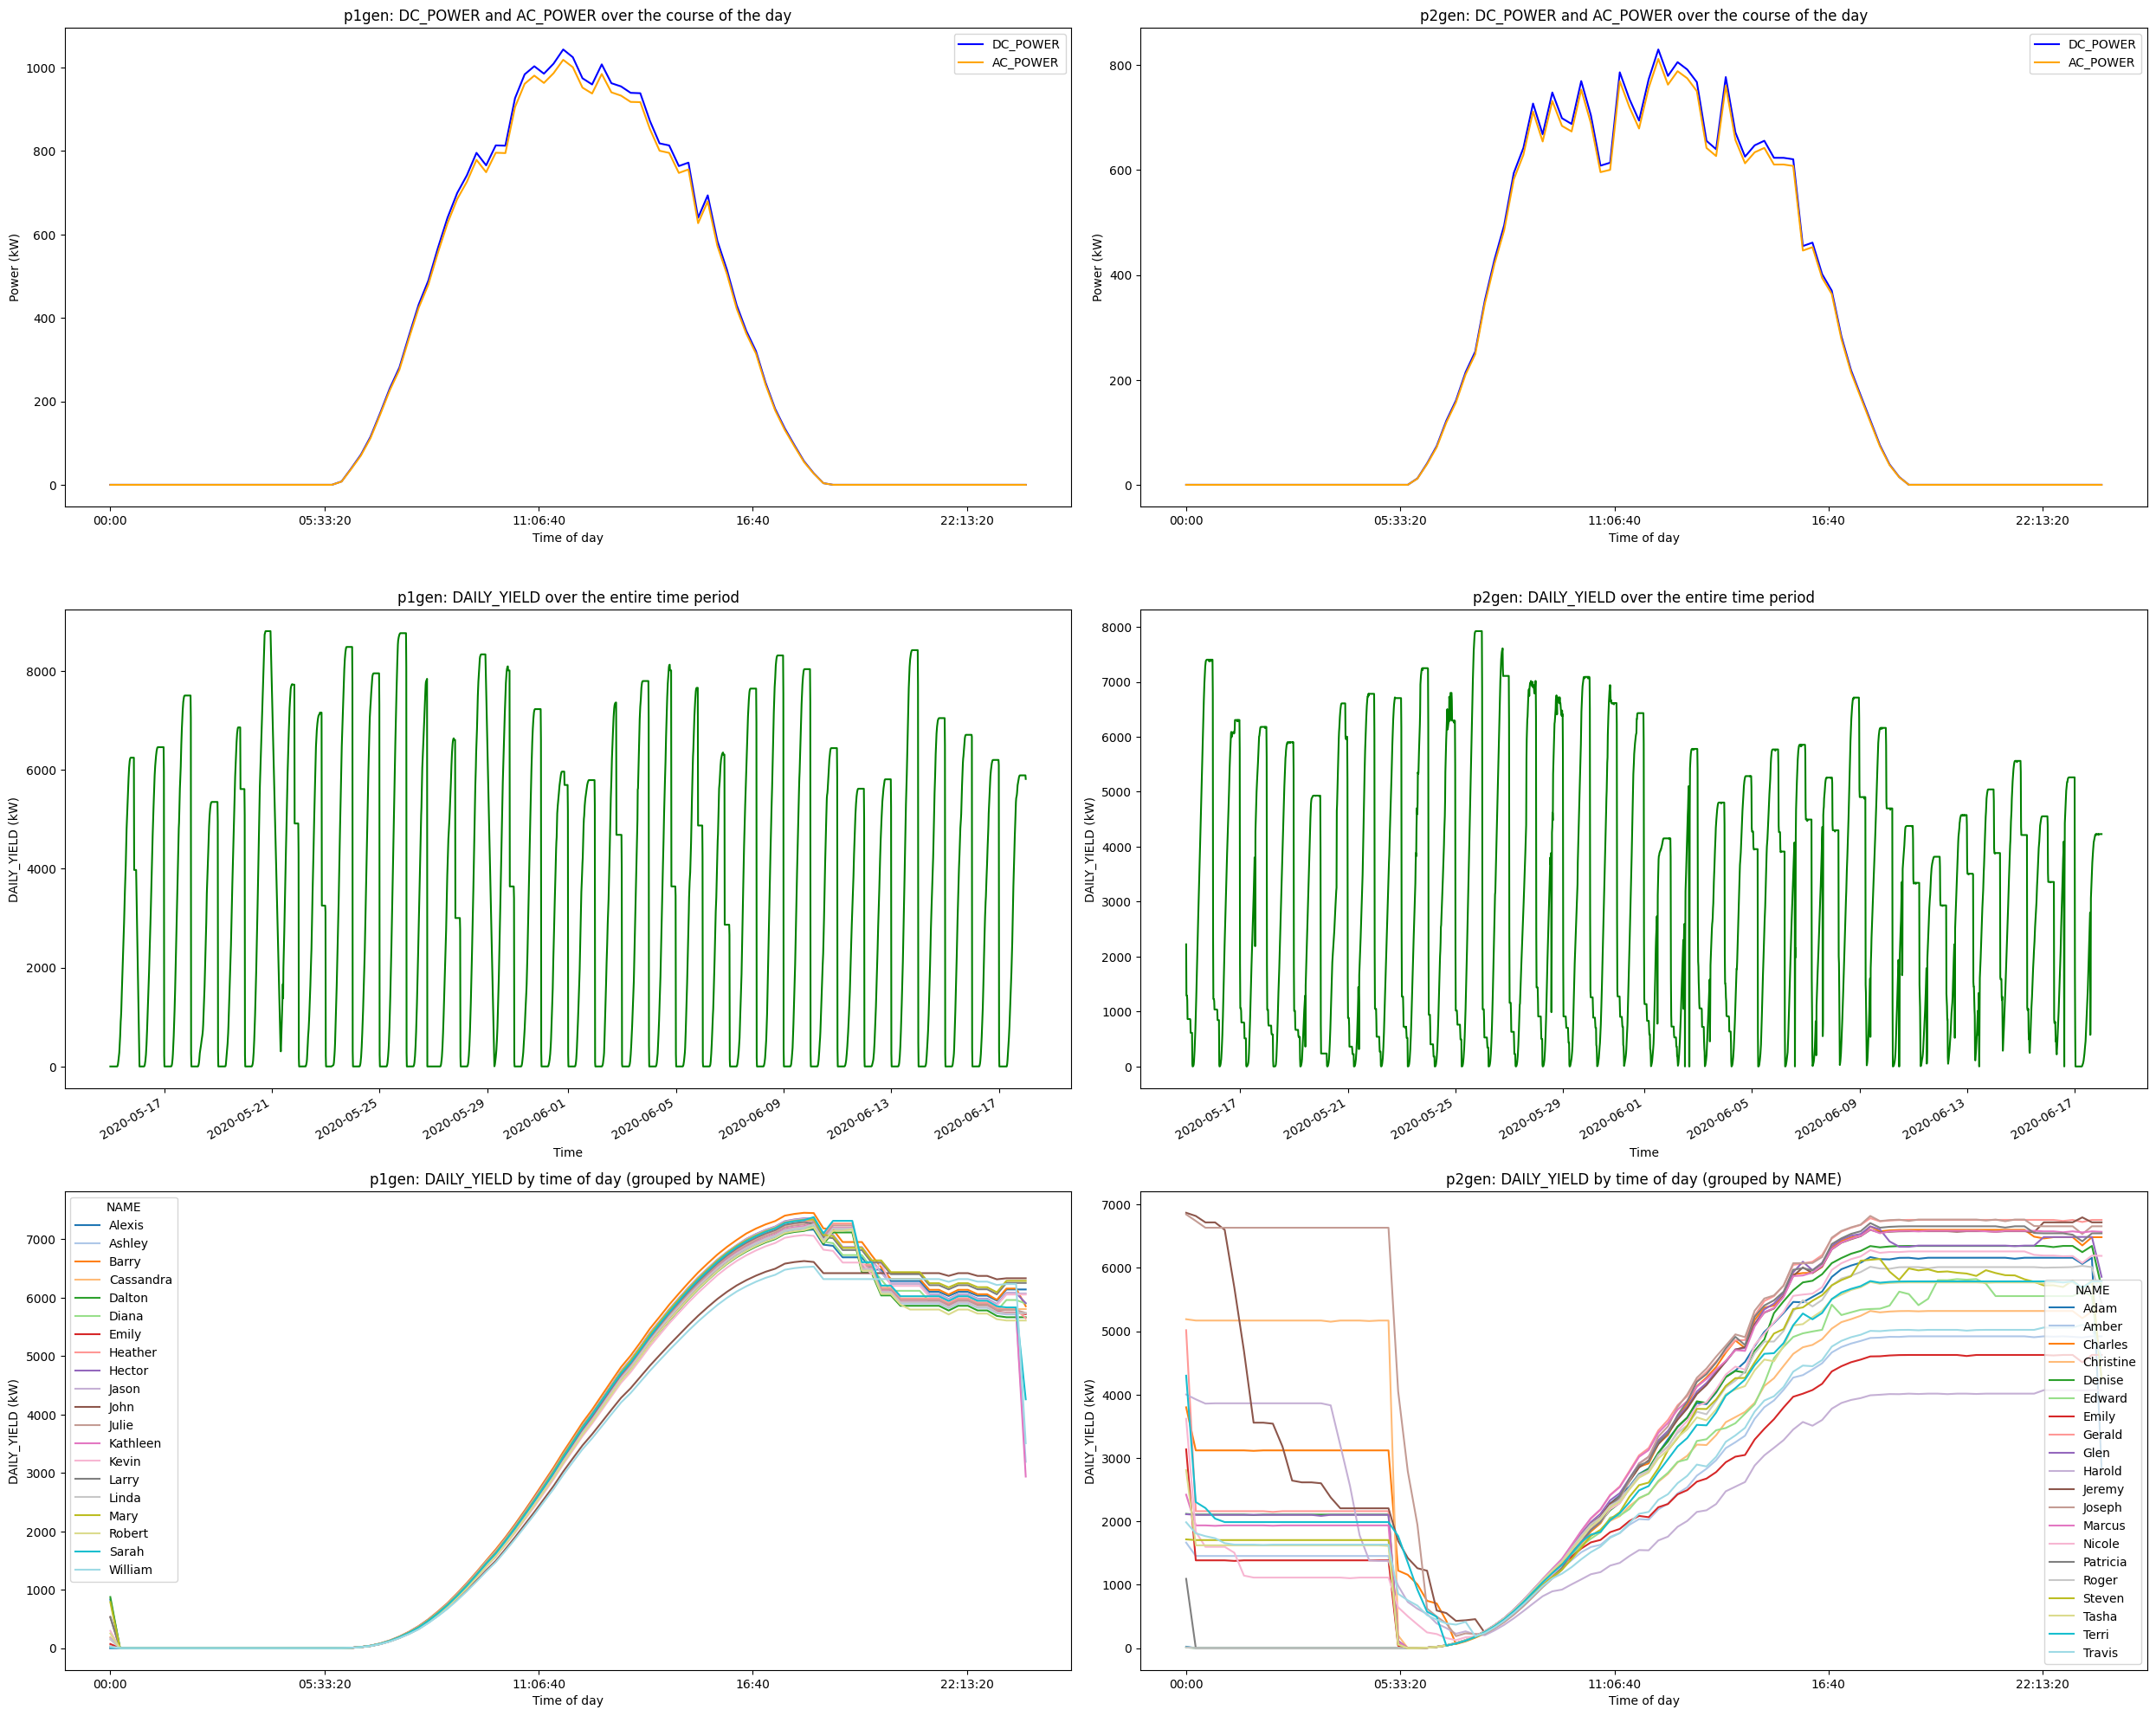

In [55]:
# Convert DATE_TIME to datetime format
p1gen['DATE_TIME'] = pd.to_datetime(p1gen['DATE_TIME'])
p2gen['DATE_TIME'] = pd.to_datetime(p2gen['DATE_TIME'])

# Extract time from DATE_TIME
p1gen['time'] = p1gen['DATE_TIME'].dt.time
p2gen['time'] = p2gen['DATE_TIME'].dt.time

# 1. Average DC_POWER and AC_POWER over the course of the day
daily_power_p1 = p1gen.groupby('time')[['DC_POWER', 'AC_POWER']].median()
daily_power_p2 = p2gen.groupby('time')[['DC_POWER', 'AC_POWER']].median()

# 2. DAILY_YIELD over the entire time period
time_series_yield_p1 = p1gen.groupby('DATE_TIME')['DAILY_YIELD'].mean()
time_series_yield_p2 = p2gen.groupby('DATE_TIME')['DAILY_YIELD'].mean()

# 3. DAILY_YIELD by time of day, grouped by NAME
yield_by_name_time_p1 = p1gen.groupby(['time', 'NAME'])['DAILY_YIELD'].mean().unstack()
yield_by_name_time_p2 = p2gen.groupby(['time', 'NAME'])['DAILY_YIELD'].mean().unstack()

# Visualization
fig, ax = plt.subplots(3, 2, figsize=(25, 20), dpi=100)

# 1. DC_POWER and AC_POWER over the course of the day
daily_power_p1.plot(ax=ax[0, 0], title="p1gen: DC_POWER and AC_POWER over the course of the day", color=['blue', 'orange'])
daily_power_p2.plot(ax=ax[0, 1], title="p2gen: DC_POWER and AC_POWER over the course of the day", color=['blue', 'orange'])
ax[0, 0].set_xlabel("Time of day")
ax[0, 0].set_ylabel("Power (kW)")
ax[0, 1].set_xlabel("Time of day")
ax[0, 1].set_ylabel("Power (kW)")

# 2. DAILY_YIELD over the entire time period
time_series_yield_p1.plot(ax=ax[1, 0], title="p1gen: DAILY_YIELD over the entire time period", color='green')
time_series_yield_p2.plot(ax=ax[1, 1], title="p2gen: DAILY_YIELD over the entire time period", color='green')
ax[1, 0].set_xlabel("Time")
ax[1, 0].set_ylabel("DAILY_YIELD (kW)")
ax[1, 1].set_xlabel("Time")
ax[1, 1].set_ylabel("DAILY_YIELD (kW)")

# 3. DAILY_YIELD by time of day, grouped by NAME
yield_by_name_time_p1.plot(ax=ax[2, 0], title="p1gen: DAILY_YIELD by time of day (grouped by NAME)", colormap='tab20')
yield_by_name_time_p2.plot(ax=ax[2, 1], title="p2gen: DAILY_YIELD by time of day (grouped by NAME)", colormap='tab20')
ax[2, 0].set_xlabel("Time of day")
ax[2, 0].set_ylabel("DAILY_YIELD (kW)")
ax[2, 1].set_xlabel("Time of day")
ax[2, 1].set_ylabel("DAILY_YIELD (kW)")

# Adjust layout and display
plt.tight_layout()
plt.savefig("Overview_p1gen_and_p2gen.png")
plt.show()

In [56]:
p1weather.describe()

,DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3182,3182.0,3182.000000,3182.000000,3182.000000
mean,2020-06-01 05:52:22.080452608,4135001.0,25.531606,31.091015,0.228313
min,2020-05-15 00:00:00,4135001.0,20.398505,18.140415,0.000000
25%,2020-05-23 22:48:45,4135001.0,22.705182,21.090553,0.000000
50%,2020-06-01 09:52:30,4135001.0,24.613814,24.618060,0.024653
75%,2020-06-09 16:56:15,4135001.0,27.920532,41.307840,0.449588
max,2020-06-17 23:45:00,4135001.0,35.252486,65.545714,1.221652
std,NaN,0.0,3.354856,12.261222,0.300836


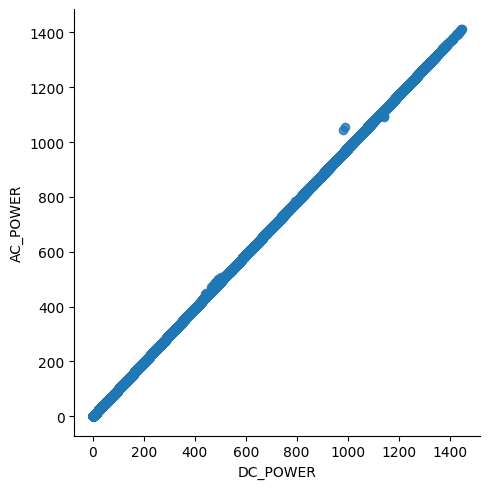

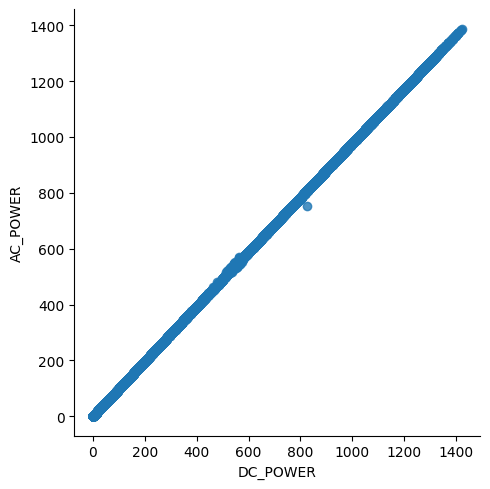

In [57]:
sns.lmplot(data=p1gen, x="DC_POWER", y="AC_POWER")
sns.lmplot(data=p2gen, x="DC_POWER", y="AC_POWER")

outliers must be error in inverter

In [58]:
def datetime_to_float(dt):
    return dt.day + dt.hour / 24 + dt.minute / 1440

# Neue Spalte mit den umgewandelten Werten hinzufügen
p1gen['DATETIME_FLOAT'] = p1gen['DATE_TIME'].apply(datetime_to_float)
p2gen['DATETIME_FLOAT'] = p2gen['DATE_TIME'].apply(datetime_to_float)
p1weather['DATETIME_FLOAT'] = p1weather['DATE_TIME'].apply(datetime_to_float)
p2weather['DATETIME_FLOAT'] = p2weather['DATE_TIME'].apply(datetime_to_float)

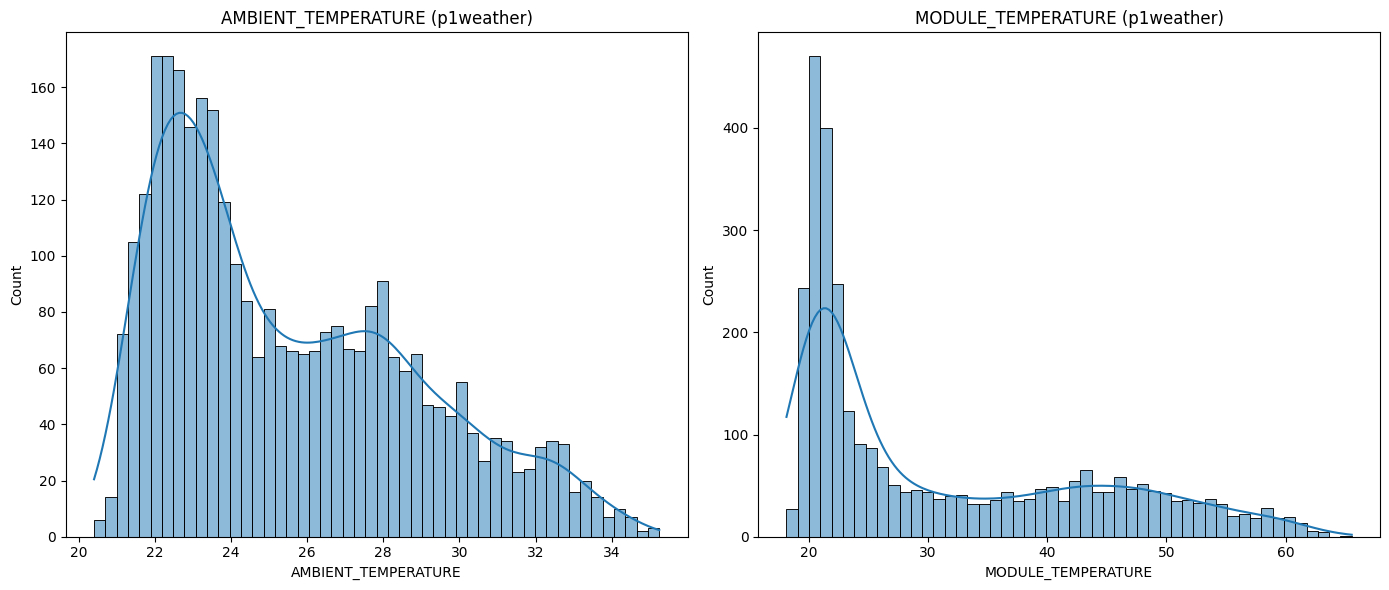

In [59]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(p1weather['AMBIENT_TEMPERATURE'], bins=50, kde=True)
plt.title('AMBIENT_TEMPERATURE (p1weather)')

plt.subplot(1, 2, 2)
sns.histplot(p1weather['MODULE_TEMPERATURE'], bins=50, kde=True)
plt.title('MODULE_TEMPERATURE (p1weather)')

plt.tight_layout()
plt.show()

In [64]:
p1gen.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,NAME,SOURCE_ID,time,DATETIME_FLOAT
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,John,1,00:00:00,15.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,Hector,2,00:00:00,15.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,Jason,3,00:00:00,15.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,Alexis,4,00:00:00,15.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,Sarah,5,00:00:00,15.0


In [61]:
p1gen.columns

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD', 'NAME', 'SOURCE_ID', 'time',
       'DATETIME_FLOAT'],
      dtype='object')

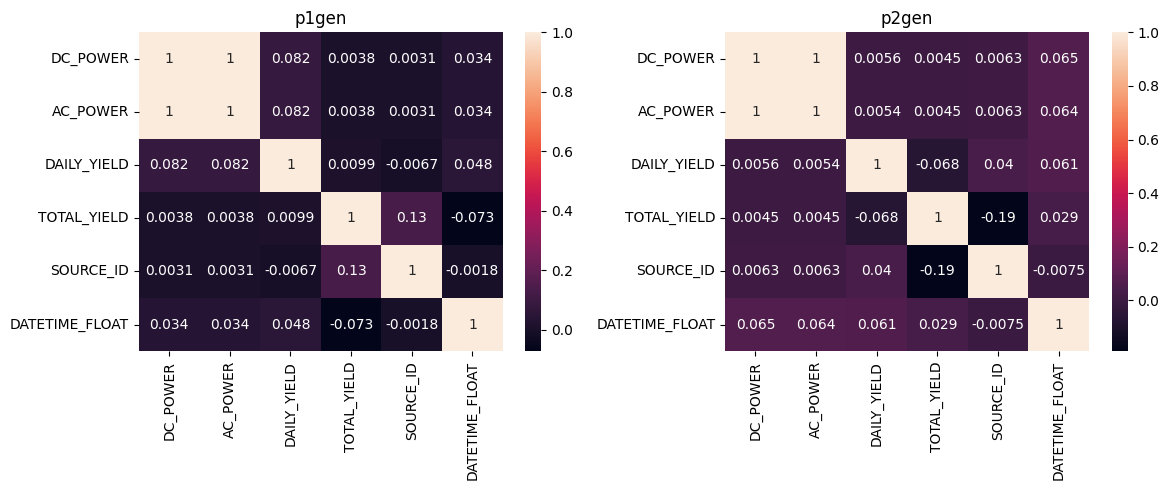

In [79]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.heatmap(p1gen[['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'SOURCE_ID', 'DATETIME_FLOAT']].corr(), annot=True)
plt.title('p1gen')
plt.subplot(1, 2, 2)
sns.heatmap(p2gen[['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'SOURCE_ID', 'DATETIME_FLOAT']].corr(), annot=True)
plt.title('p2gen')
plt.tight_layout()
plt.show()

<Axes: >

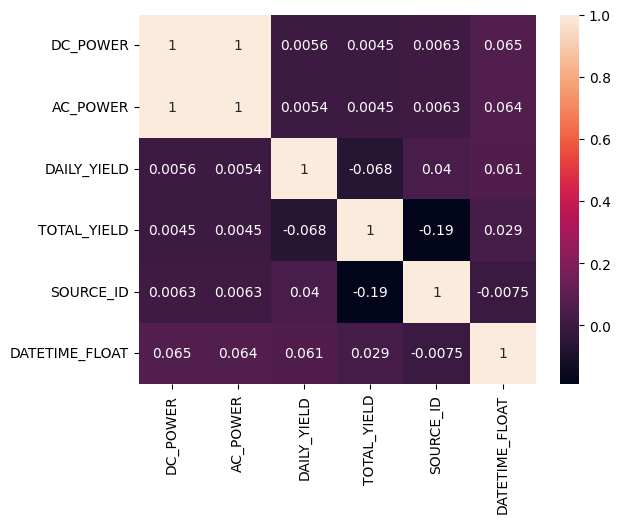

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.heatmap(p1weather[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DATETIME_FLOAT']].corr(), annot=True)
plt.title('p1weather')
plt.subplot(1, 2, 2)
sns.heatmap(p2weather[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DATETIME_FLOAT']].corr(), annot=True)
plt.title('p2weather')
plt.tight_layout()
plt.show()